In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from datetime import timedelta
import matplotlib.dates as mdates
import sumolib
import osmnx as ox

import sys
import os
import logging
import subprocess
import numpy as np

from fastsim import simdrive, vehicle, cycle
from fastsim import parameters as params

import traci
import time
import csv

import xml.etree.ElementTree as ET
import xml.dom.minidom

In [2]:
os.environ['PATH'] += ":/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo/bin"
# Set SUMO_HOME
os.environ['SUMO_HOME'] = '/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo'

In [3]:
# In terminal:
# osmGet.py --bbox="-94.073366,44.403672,-92.696696,45.450154" --prefix Minneapolis -d data
# export SUMO_HOME='/home/shekhars/yang7492/.conda/envs/syntheticData/lib/python3.8/site-packages/sumo'
# osmBuild.py --prefix Minneapolis --osm-file data/Minneapolis_bbox.osm.xml --vehicle-classes passenger --netconvert-options="--geometry.remove,--ramps.guess,--tls.guess-signals,--tls.discard-simple,--remove-edges.isolated" --output-directory data

In [4]:
net_file = 'data/Minneapolis.net.xml'
net = sumolib.net.readNet(netfile)

In [5]:
def read_matched_trip_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Convert string representations of lists or tuples back to lists or tuples
    # Use ast.literal_eval safely evaluate a string containing a Python literal or container display
    df['altitude_profile'] = df['altitude_profile'].apply(ast.literal_eval)
    df['velocity_profile'] = df['velocity_profile'].apply(ast.literal_eval)
    df['weight'] = df['weight'].apply(ast.literal_eval)
    df['total_fuel'] = df['total_fuel'].apply(ast.literal_eval)
    df['trajectory'] = df['trajectory'].apply(ast.literal_eval)
    df['matched_path'] = df['matched_path'].apply(ast.literal_eval)
    df['coordinate_id'] = df['coordinate_id'].apply(ast.literal_eval)
    df['road_id'] = df['road_id'].apply(ast.literal_eval)
    
    # Remove fractional seconds from 'time'
    df['trip_start_time'] = df['trip_start_time'].str.split('.').str[0]
    # Convert 'time' to datetime while ignoring fractional seconds
    df['trip_start_time'] = pd.to_datetime(df['trip_start_time'], format='%Y-%m-%d %H:%M:%S')

    df['trip_end_time'] = df['trip_end_time'].str.split('.').str[0]
    df['trip_end_time'] = pd.to_datetime(df['trip_end_time'], format='%Y-%m-%d %H:%M:%S')
    return df

In [6]:
# Example usage:
csv_file = "data/matchedTrips/Murphy/TL5-218_2020W33_matched.csv"
matched_trip_data = read_matched_trip_data(csv_file)
print(matched_trip_data.head(2))

      trip_start_time       trip_end_time  travel_time  \
0 2020-08-10 12:28:47 2020-08-10 13:13:17       2670.0   
1 2020-08-10 13:40:07 2020-08-10 13:57:35       1048.0   

                                    altitude_profile  \
0  [255.7, 255.2, 254.7, 254.2, 253.8, 252.9, 252...   
1  [271.3, 272.8, 274.6, 276.8, 279.6, 281.9, 284...   

                                    velocity_profile  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              weight  \
0  [30000.0, 30000.0, 30000.0, 30000.0, 30000.0, ...   
1  [8000.0, 8000.0, 8000.0, 8000.0, 8000.0, 8000....   

                                          total_fuel  ambTemperature  \
0  [4.15, 4.15, 4.05, 4.1, 3.75, 3.8, 5.3, 6.25, ...          15.188   
1  [4.1, 4.05, 4.15, 4.1, 4.1, 4.25, 4.1, 4.1, 4....          16.875   

                                          trajectory  \
0  [(44.788085, -93.462496), (44.78809, -93.4

In [11]:
edgeList = matched_trip_data.loc[0, "matched_path"]
nodeList = [edge[0] for edge in edgeList]
nodeList.append(edgeList[-1][1])

In [9]:
def findEdgeIdBetween(net, u, v):
    for edge in net.getEdges():
        if edge.getFromNode().getID() == u and edge.getToNode().getID() == v:
            return edge.getID()
    return None

In [15]:
def valid_nodeList(nodeList, net):
    '''
    :return: a valid sub-list by dropping the unmatched nodes from nodeList
    '''
    nodeList = [str(x) for x in nodeList]
    # Iterate through edges and find those that connect the specified nodes
    matching_edges = []
    nodes = []
    for n in nodeList:
        if net.hasNode(str(n)):
            nodes.append(n)
    return nodes

In [19]:
def find_valid_edge_route(nodeList, net):
    '''
    :return: (str) an edge route that contains only the edges within the net
    '''
    edge_route = ''
    for i in range(len(nodeList)-1):
        found = False
        edgeId = findEdgeIdBetween(net, nodeList[i], nodeList[i+1])
        if edgeId is not None:
            edge_route += edgeId + ' '
        else:
            found = False
            origin_to = []
            from_dest = []
            
            for edge in net.getEdges():
                if edge.getFromNode().getID() == nodes[i]:
                    origin_to.append(edge.getToNode().getID())

                if edge.getToNode().getID() == nodes[i+1]:
                    from_dest.append(edge.getFromNode().getID())

            for candidate in origin_to:
                if candidate in from_dest:
                    edgeIdPart1 = findEdgeIdBetween(net, nodes[i], candidate)
                    edgeIdPart2 = findEdgeIdBetween(net, candidate, nodes[i+1])
                    edge_route += edgeIdPart1 + ' '+ edgeIdPart2 + ' '
                    break
    return edge_route

In [21]:
nodeList = valid_nodeList(nodeList, net)
edge_route = find_valid_edge_route(nodeList, net)

In [22]:
edge_route

'18237140#25 18237140#27 640843254#0 640843254#1 640843254#2 640843254#6 640843257 1080549317 1201539002#0 1201539002#2 1027628929#1 998758729#0 39195141 640724411 1059581969 39293602 39293515-AddedOnRampEdge 39293515 188375339 188375339-AddedOffRampEdge 998971293 39292733 721031730 1000765647 39291048#0 39291048#1-AddedOnRampEdge 39291048#1 998973130#0 39287927 157480091 926034888#2-AddedOnRampEdge 926034888#2 926033941 996223918 996223917 35394439 996217403 996217404 35394580 998687580#0 998687580#2-AddedOnRampEdge 998687580#2 996316019#0 1012096920 1012096919 43406446 35394582 560245486 183246965 991954560#1-AddedOnRampEdge 991954560#1 638798741-AddedOnRampEdge 638798741 638798750 638798750-AddedOffRampEdge 86291317 638798749-AddedOnRampEdge 638798749 86291326#0 179909220 123445123 1081071868 1009623659 61851512 1021849049 61851513 638798751 734281195 61849502 61848035 61848035-AddedOffRampEdge 1120046302 734275199 1081069760-AddedOnRampEdge 1081069760 734275187 734275188#1-AddedOnR

In [31]:
# the result route is incomplete, use duarouter in SUMO to complete it
# https://sumo.dlr.de/docs/Definition_of_Vehicles%2C_Vehicle_Types%2C_and_Routes.html#incomplete_routes_trips_and_flows

def save_incomplete_routes_to_xml(routes_info, xml_file_path):
    """
    Save multiple routes to an XML file in the specified format.
    
    :param routes_info: A list of dictionaries, each representing a route. 
                        Each dictionary should have the following keys:
                        - 'edge_route': a string of space-separated edge IDs representing the route
                        - 'trip_id': a unique identifier for the trip
                        - 'depart_time': the departure time for the trip
    :param xml_file_path: The path where the XML file will be saved
    
    Each route will be represented as a <trip> element in the XML file with the following attributes:
        - id: the trip_id of the route
        - depart: the depart_time of the route
        - from: the first edge ID in the edge_route
        - to: the last edge ID in the edge_route
        - via: a space-separated string of the intermediate edge IDs in the edge_route
    """
    
    # Create the root element <routes>
    routes = ET.Element("routes")
    
    for route_info in routes_info:
        # Extract route information
        edge_route, trip_id, depart_time = route_info['edge_route'], route_info['trip_id'], route_info['depart_time']
        # Create a <trip> element for each route
        trip = ET.SubElement(routes, "trip")
        
        # Split the edge_route string into individual edges
        edges = edge_route.strip().split()
        
        # Set attributes for the <trip> element
        trip.set("id", trip_id)
        trip.set("depart", str(depart_time))
        trip.set("from", edges[0])
        trip.set("to", edges[-1])
        trip.set("via", " ".join(edges[1:-1]))  # Include all edges except the first and last
    
    # Create an ElementTree object and write the XML structure to the specified file
    tree = ET.ElementTree(routes)
    tree.write(xml_file_path, encoding='utf-8', xml_declaration=True)

In [32]:
def edge_route_to_routes_info(edge_route:str, trip_id:str, depart_time:str):
    """
    Convert an edge_route to the routes_info format.
    
    :param edge_route: A string of space-separated edge IDs representing the route.
    :param trip_id: A unique identifier for the trip.
    :param depart_time: The departure time for the trip.
    
    :return: A dictionary in the routes_info format.
    """
    
    # Create the routes_info dictionary
    routes_info = {
        "edge_route": edge_route,
        "trip_id": trip_id,
        "depart_time": depart_time
    }
    return routes_info

In [33]:
route_file = "data/incompelete_routes.xml"
routes_info = [edge_route_to_routes_info(edge_route, "t1", 0)]
save_incomplete_routes_to_xml(routes_info, route_file)
complete_route_file = 'data/complete_routes.rou.xml'

In [34]:
# Complete the routes:
# duarouter --route-files data/incompelete_routes.xml --net-file data/Minneapolis.net.xml --output-file data/complete_routes.rou.xml
def complete_routes(route_file, net_file, output_file):
    logging.info("Running external command...")
    command = 'duarouter'
    args = [
        '--route-files', route_file,
        '--net-file', net_file,
        '--output-file', output_file
    ]
    
    try:
        result = subprocess.run([command] + args, capture_output=True, text=True)
        result.check_returncode()  # Raises CalledProcessError if command failed
        logging.info("External command executed successfully.")
    except subprocess.CalledProcessError as e:
        logging.error(f"Error in executing external command: {e}")
        raise  # Re-raise the exception if you want to handle it at a higher level or halt the script

In [38]:
complete_routes(route_file, net_file, complete_route_file)

In [40]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element."""
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = xml.dom.minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="    ")

def save_sumo_config_to_file(net_file, route_file, begin, end, step_length, file_name):
    # Create the root element
    configuration = ET.Element("configuration")

    # Create the input element and its children
    input_elem = ET.SubElement(configuration, "input")
    ET.SubElement(input_elem, "net-file", value=net_file)
    ET.SubElement(input_elem, "route-files", value=route_file)

    # Create the time element and its children
    time = ET.SubElement(configuration, "time")
    ET.SubElement(time, "begin", value=str(begin))
    ET.SubElement(time, "end", value=str(end))
    ET.SubElement(time, "step-length", value=str(step_length))

    xml_pretty_str = prettify(configuration)

    # Save the string to a file
    with open(file_name, 'w') as file:
        file.write(xml_pretty_str)

In [41]:
begin = 0
end = 10800
step_length = 1
file_name_config = "sumo.sumocfg"
save_sumo_config_to_file(net_file, complete_route_file, begin, end, step_length, file_name_config)

In [44]:
class TraciSimulation:
    def __init__(self, sumoCmd):
        self.sumoCmd = sumoCmd

    def __enter__(self):
        traci.start(self.sumoCmd)
        return traci  # Return the traci instance to be used within the 'with' block

    def __exit__(self, exc_type, exc_value, traceback):
        traci.close()  # Close Traci when exiting the 'with' block
        # Handle exceptions if necessary
        if exc_type:
            print(f"An error occurred: {exc_value}")
            # Return False to propagate the exception, True to suppress

def sumo_simulation(file_name_config, vehicle_ids):
    # Connect to SUMO
    sumoCmd = ['sumo', '-c', file_name_config]
    with TraciSimulation(sumoCmd) as ts:
        velocity_data = {vid: [] for vid in vehicle_ids}
        edgeSeq_data = {vid: [] for vid in vehicle_ids}
        recorded_cars = []
        all_routes = []

        count = 0
        while ts.simulation.getMinExpectedNumber() > 0:
            for moving_car in ts.vehicle.getIDList():
                if moving_car not in recorded_cars:
                    recorded_cars.append(moving_car)
                    all_routes.append(ts.vehicle.getRoute(moving_car))
            for vehicle_id in vehicle_ids:
                if vehicle_id in ts.vehicle.getIDList():
                    speed = ts.vehicle.getSpeed(vehicle_id)
                    cur_edge = ts.vehicle.getRoadID(vehicle_id)
                    edgeSeq_data[vehicle_id].append(cur_edge)
                    velocity_data[vehicle_id].append(speed)
            count += 1
            ts.simulationStep()
    return velocity_data, edgeSeq_data

In [45]:
vehicle_ids = ["t1"]
velocity_data, edgeSeq_data = sumo_simulation(file_name_config, vehicle_ids)
print(len(velocity_data["t1"]))

 Retrying in 1 seconds
Step #1793.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 1 ACT 0 BUF 0)                    
1792


In [46]:
velocityProfile = velocity_data["t1"]
velocityProfile = [3.6*x for x in velocityProfile]

In [47]:
all_speedLimits = []
edgeSeq = edgeSeq_data["t1"]
for edge in edgeSeq:
    if net.hasEdge(edge):
        speedLimit = 3.6*net.getEdge(edge).getSpeed()
    else:
        speedLimit = all_speedLimits[-1]
    all_speedLimits.append(speedLimit)

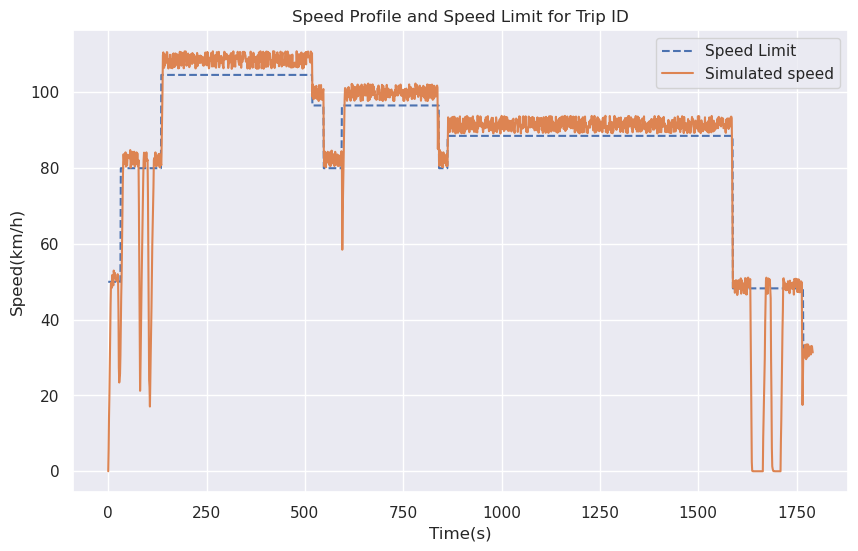

In [49]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the speed limits
plt.plot(all_speedLimits, label='Speed Limit', linestyle='--')

# Plot the simulated speed
plt.plot(velocityProfile, label='Simulated speed')


# Adding titles and labels
plt.title(f'Speed Profile and Speed Limit for Trip ID')
plt.xlabel('Time(s)')
plt.ylabel('Speed(km/h)')
plt.legend()

plt.show()

In [50]:
def run_fastsim_simulation(all_speeds, veh):
    # Vehicle_id description: https://github.com/NREL/fastsim/blob/fastsim-2/python/fastsim/resources/FASTSim_py_veh_db.csv
    # Convert speeds from km/h to m/s
    all_speeds_ms = [x / 3.6 for x in all_speeds]
    mps = np.array(all_speeds_ms)
    time_s = np.arange(0, len(mps))
    grade = np.zeros(len(mps))
    road_type = np.zeros(len(mps))

    accel_cyc = {'mps': mps, 'time_s': time_s, 'grade': grade, 'road_type': road_type}

 
    cyc = cycle.Cycle.from_dict(cyc_dict=accel_cyc)

    # Run simulation
    sim_drive = simdrive.SimDrive(cyc, veh)
    sim_drive.sim_drive()
    
    # Assuming sim_drive.fc_kw_in_ach is your list of power values in kW
    power_data = sim_drive.fc_kw_in_ach

    # Convert power data to a NumPy array for easier calculations
    power_array = np.array(power_data)

    # Calculate cumulative energy in kWh
    # Each power data point is assumed to represent one second
    cumulative_energy_kWh = np.cumsum(power_array) / 3600  # converting kWs to kWh
    
    speedProfileInKmh = np.array(sim_drive.mph_ach)*1.609344
    
    
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(9, 5))
    ax[0].plot(cyc.time_s, sim_drive.fc_kw_in_ach, label='py')
    ax[0].legend()
    ax[0].set_ylabel('Engine Input\nPower [kW]')

    ax[1].plot(cyc.time_s, sim_drive.mph_ach)
    ax[1].set_xlabel('Cycle Time [s]')
    ax[1].set_ylabel('Speed [MPH]')

    plt.show()

    return power_array, cumulative_energy_kWh, speedProfileInKmh


2024-01-25 15:21:36.156 | simdrive.py:2280 | WARNING: trace miss distance fraction 0.03745 exceeds tolerance of 0.001
2024-01-25 15:21:36.158 | simdrive.py:2298 | WARNING: trace miss speed 10.01978 m/s exceeds tolerance of 1.0 m/s


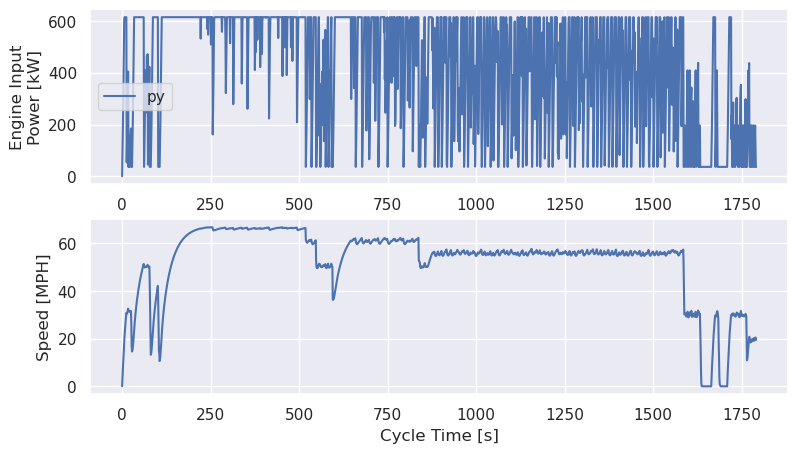

In [51]:
# fastsim part
power_array_simulated, cumulative_energy_kWh_simulated, speed_simulated  = run_fastsim_simulation(velocityProfile, 25)

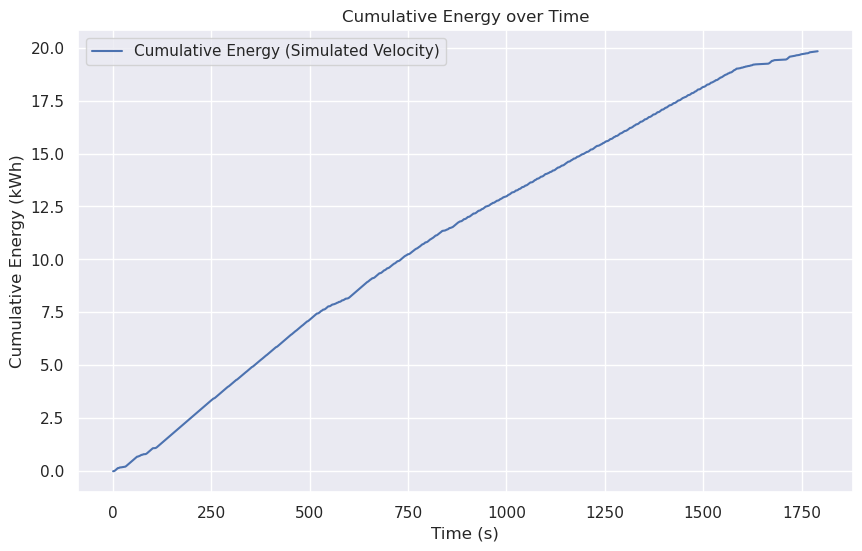

In [52]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(cumulative_energy_kWh_simulated)), cumulative_energy_kWh_simulated/40.3*3.7854, label='Cumulative Energy (Simulated Velocity)')
plt.xlabel('Time (s)')
plt.ylabel('Cumulative Energy (kWh)')
plt.title('Cumulative Energy over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
edgeList = matched_trip_data.loc[0, "matched_path"]
nodeList = [edge[0] for edge in edgeList]
nodeList.append(edgeList[-1][1])

nodeList = valid_nodeList(nodeList, net)
edge_route = find_valid_edge_route(nodeList, net)

route_file = "data/incompelete_routes.xml"
complete_route_file = 'data/complete_routes.rou.xml'
vehicle_ids = ["t1"]
enter_time = [0]

# a set of routes to be processed
routes_info = [edge_route_to_routes_info(edge_route, vehicle_ids[0], enter_time[0])]
save_incomplete_routes_to_xml(routes_info, route_file)
complete_routes(route_file, net_file, complete_route_file)

begin = 0
end = 10800
step_length = 1
file_name_config = "sumo.sumocfg"
save_sumo_config_to_file(net_file, complete_route_file, begin, end, step_length, file_name_config)

velocity_data, edgeSeq_data = sumo_simulation(file_name_config, vehicle_ids)

velocityProfile = velocity_data[vehicle_ids[0]]
velocityProfile = [3.6*x for x in velocityProfile]

# fastsim part
# Initialize vehicle
# 25: Regional Delivery Class 8 Truck; 26: Line Haul Conv
veh = vehicle.Vehicle.from_vehdb(25)
# veh.veh_override_kg = 8000   
power_array_simulated, cumulative_energy_kWh_simulated, speed_simulated  = run_fastsim_simulation(velocityProfile, veh)

In [59]:
# 1. generate timeslots for simulation
# 2a. determine the timeslots and the entrance time stamp for each trip, 
# 2b. if the trips anticipated ending time exceed the predifined timeslot, extend the timeslot
# 3. for the trips within the same timeslot, define trips id for them, generate the routes together and do the simulation.
# 4. Save the route, the velocity, the power list for each time stamp. Note that a route may need to be saved as node pairs to connect to origin edges.

In [54]:
veh = vehicle.Vehicle.from_vehdb(25)

In [56]:
veh.veh_override_kg = 8000

In [58]:
veh

Vehicle(scenario_name='Regional Delivery Class 8 Truck', selection=25, veh_year=0, veh_pt_type='Conv', drag_coef=0.8, frontal_area_m2=10.0, glider_kg=13625.0, veh_cg_m=0.53, drive_axle_weight_frac=0.59, wheel_base_m=2.7536, cargo_kg=136.0, veh_override_kg=8000, comp_mass_multiplier=1.4, fs_max_kw=5000.0, fs_secs_to_peak_pwr=1.0, fs_kwh=4000.0, fs_kwh_per_kg=9.875636446, fc_max_kw=212.0, fc_pwr_out_perc=array([0.   , 0.005, 0.015, 0.04 , 0.06 , 0.1  , 0.14 , 0.2  , 0.4  ,
       0.6  , 0.8  , 1.   ]), fc_eff_map=array([0.1 , 0.14, 0.2 , 0.26, 0.32, 0.39, 0.41, 0.42, 0.41, 0.38, 0.36,
       0.34]), fc_eff_type='Diesel', fc_sec_to_peak_pwr=6.0, fc_base_kg=61.0, fc_kw_per_kg=0.62, min_fc_time_on=30.0, idle_fc_kw=4.24, mc_max_kw=0.0, mc_pwr_out_perc=array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.2 , 0.4 , 0.6 , 0.8 , 1.  ]), mc_eff_map=array([0.12, 0.16, 0.21, 0.29, 0.35, 0.42, 0.75, 0.92, 0.93, 0.93, 0.92]), mc_sec_to_peak_pwr=4.0, mc_pe_kg_per_kw=0.833, mc_pe_base_kg=21.6, ess_max_kw=0.0, 